### 研学专题

In [57]:
# -*- coding: utf-8 -*-
import requests
import time
import os
import jieba
import re
import glob
import math
import ssl
import pandas as pd
import geopandas as gpd
from requests.adapters import HTTPAdapter
import json
import random
from concurrent.futures import ThreadPoolExecutor, as_completed
from snownlp import SnowNLP
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from scipy.stats import gaussian_kde
from shapely.geometry import Point

In [58]:
import networkx as nx
from itertools import combinations
from collections import Counter
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ListedColormap
import community

### 读取所有评论和选择研学相关的评论

In [60]:
comments_df = pd.read_csv('./data/区域景区评论汇总.csv', encoding='utf-8-sig')

C:\Users\lenovo\AppData\Local\Temp\ipykernel_46364\3365735254.py:1: DtypeWarning: Columns (12,15) have mixed types. Specify dtype option on import or set low_memory=False.
  comments_df = pd.read_csv('./data/区域景区评论汇总.csv', encoding='utf-8-sig')


In [13]:
study_keywords = ['研学',"研学旅行", "研学团", "研学活动", "研学营", "研学基地", 
    "学生团", "学校组织", "带孩子来学习", "寓教于乐", "教育基地",'学习', '教育', '学校', '学生','营地','银发','夏令营','冬令营'] # 意思是：包含"研学" OR "学习" OR "教育" OR "学校" OR "学生" #

age_keywords = {
    "小学": ["小学", "小学生"],
    "初中": ["初中", "初中生", "初一", "初二", "初三"],
    "高中": ["高中", "高中生", "高一", "高二", "高三"],
    "大学": ["大学", "大学生", "本科", "研究生"]
}

In [14]:
def is_study_related(text):
    return any(kw in text for kw in study_keywords)

def extract_age_group(text):
    for age_group, kws in age_keywords.items():
        if any(kw in text for kw in kws):
            return age_group
    return None

#### 筛选研学相关的言论

In [15]:
import re
study_pattern = re.compile("|".join(study_keywords))
comments_df["is_study"] = comments_df["content"].str.contains(study_pattern, na=False)
study_comments = comments_df["is_study"].sum()
study_comments

33639

In [16]:
study_df = comments_df[comments_df["is_study"] == True].copy()
# study_df["age_group"] = study_df["content"].apply(extract_age_group)

In [17]:
study_df.shape

(33639, 20)

In [ ]:
# = study_df.drop_duplicates(subset="content").reset_index(drop=False)

#### 用sklearnlda进行分析

In [18]:
def prepare_texts_basic(df, stopwords_path, min_length=5):
    """
    基础文本处理：分词 + 停用词过滤 + 长度过滤 + 保留 commentId 对应关系
    返回值：
        texts_cut: [(commentId, [分词结果])]
        共 N 条有效评论
    """

    # 加载停用词
    with open(stopwords_path, "r", encoding="utf-8") as f:
        stopwords = set(w.strip() for w in f if w.strip())

    # 分词 + 停用词过滤
    texts_cut = []
    for cid, text in zip(df["commentId"], df["content"].astype(str)):
        words = [
            w for w in jieba.cut(text)
            if w not in stopwords and len(w) > 1 and not w.isdigit()
        ]
        if len(words) >= min_length:
            texts_cut.append((cid, words))  # ✅ 保留 commentId

    print(f"已完成分词与过滤，共 {len(texts_cut)} 条有效评论")
    return texts_cut

In [19]:
texts_basic = prepare_texts_basic(df= study_df, stopwords_path='./trip_stopwords.txt')

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache


Loading model cost 0.653 seconds.
Prefix dict has been built successfully.


已完成分词与过滤，共 27823 条有效评论


In [25]:
texts_basic_study = prepare_texts_basic(df= study_df, stopwords_path='./study_stopwords.txt')

已完成分词与过滤，共 25980 条有效评论


In [23]:
comment_ids = [cid for cid, _ in texts_basic_study]
texts_basic_study_body = [" ".join(words) for _, words in texts_basic_study]

##### 生成词云

In [26]:
def generate_wordcloud(docs,output_dir="./lda_results",
                       font_path="msyh.ttc", max_words=200, cmap="Blues_r", random_state=42):

    if not docs:
        print("⚠️ 输入 tokenized_docs 为空，跳过词云生成。")
        return None

    os.makedirs(output_dir, exist_ok=True)

    # 将二维分词结果拼接为一个整体字符串
    all_words = " ".join([" ".join(words) for words in docs])

    wc = WordCloud(
        font_path=font_path,
        background_color="white",
        width=1000,
        height=600,
        colormap=cmap,
        max_words=max_words,
        random_state=random_state
    ).generate(all_words)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"研学评论词云", fontsize=14)
    save_path = os.path.join(output_dir, f"study_wordcloud.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    print(f"✅ 词云已保存至: {save_path}")
    return wc

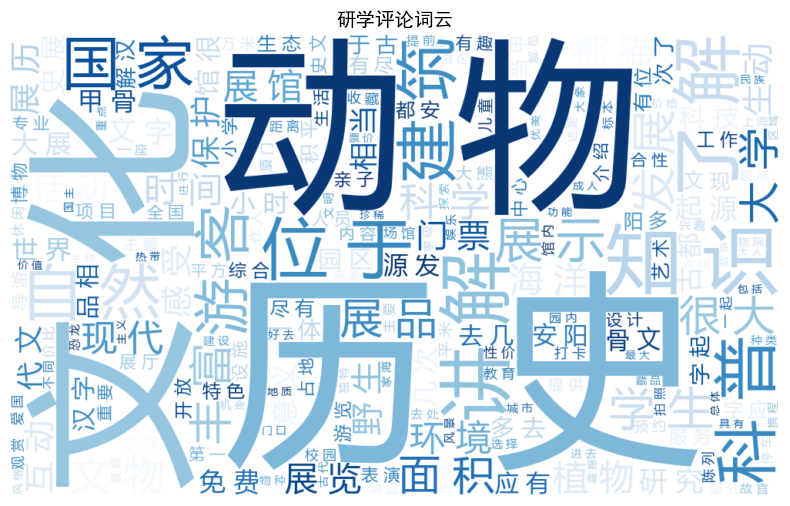

✅ 词云已保存至: ./lda_results\study_wordcloud.png


In [27]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # Windows 系统常用黑体
plt.rcParams['axes.unicode_minus'] = False 
generate_wordcloud(texts_basic_study_body)

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
# gensim.models.LdaModel	sklearn.decomposition.LatentDirichletAllocation这两个模型选哪一种
def lda_from_long_texts(texts_long, n_topics=5, max_iter=10, random_state=42): #11
    # 合并分词为字符串
    if isinstance(texts_long[0], str):
        docs_str = texts_long
    else:
        docs_str = [" ".join(doc) for doc in texts_long]

    # 构建词频矩阵
    vectorizer = CountVectorizer()
    count_matrix = vectorizer.fit_transform(docs_str)
    feature_names = vectorizer.get_feature_names_out()

    # 训练 LDA
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=max_iter,
        random_state=random_state
    )
    lda.fit(count_matrix)

    # 输出主题关键词
    topics = {}
    for i, topic in enumerate(lda.components_):
        top_words = [feature_names[j] for j in topic.argsort()[-20:][::-1]]
        topics[f'Topic {i+1}'] = top_words

    topics_df = pd.DataFrame(topics)
    return lda, count_matrix, topics_df

In [29]:
lda_model, count_matrix, topics_df = lda_from_long_texts(texts_basic_study_body, random_state=42, n_topics=8)

In [30]:
topics_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8
0,讲解,动物,历史,知识,植物,校园,知识,展馆
1,门票,科普,文化,恐龙,科普,位于,历史,历史
2,小时,游客,展示,大象,园区,建筑,科技,了解
3,时间,自然,文物,很大,游客,校区,感受,发展
4,导游,园区,展览,表演,景观,科普,互动,很大
5,知识,大熊猫,建筑,意义,热带,建设,科学,展品
6,免费,野生,国家,介绍,知识,厦门大学,丰富,相当
7,预约,保护,海洋,化石,文化,武汉大学,了解,文字
8,学生票,野生动物,位于,电影,花卉,全国,讲解,位于
9,提前,设施,平米,免费,位于,樱花,探索,现代


In [107]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(lda_model.components_)
# 转为 DataFrame 方便查看
similarity_df = pd.DataFrame(similarity, 
                             index=[f"Topic {i+1}" for i in range(lda_model.n_components)],
                             columns=[f"Topic {i+1}" for i in range(lda_model.n_components)])

print(similarity_df.round(3))

         Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  \
Topic 1    1.000    0.120    0.126    0.431    0.133    0.081    0.375   
Topic 2    0.120    1.000    0.171    0.240    0.294    0.220    0.300   
Topic 3    0.126    0.171    1.000    0.132    0.239    0.328    0.362   
Topic 4    0.431    0.240    0.132    1.000    0.187    0.121    0.402   
Topic 5    0.133    0.294    0.239    0.187    1.000    0.254    0.201   
Topic 6    0.081    0.220    0.328    0.121    0.254    1.000    0.174   
Topic 7    0.375    0.300    0.362    0.402    0.201    0.174    1.000   
Topic 8    0.058    0.033    0.226    0.104    0.044    0.088    0.150   

         Topic 8  
Topic 1    0.058  
Topic 2    0.033  
Topic 3    0.226  
Topic 4    0.104  
Topic 5    0.044  
Topic 6    0.088  
Topic 7    0.150  
Topic 8    1.000  


主题数=5, Perplexity=2447.76
主题数=6, Perplexity=2433.62
主题数=7, Perplexity=2376.11
主题数=8, Perplexity=2340.42
主题数=9, Perplexity=2342.00


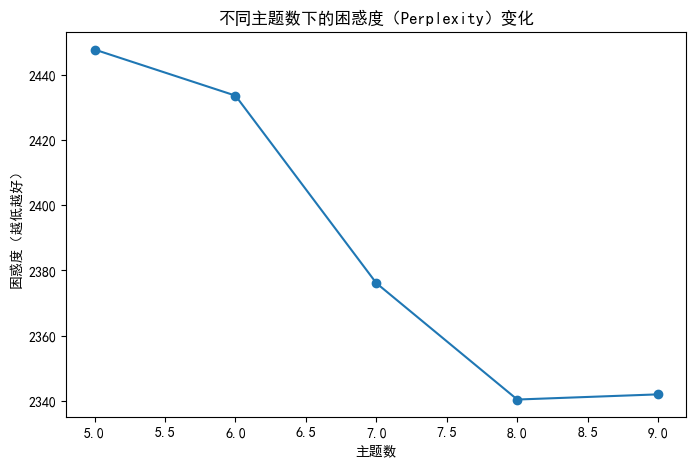

In [27]:
# 示例语料
docs = [" ".join(doc) for doc in texts_basic_study ]  # 你的分词结果
vectorizer = CountVectorizer(max_df=0.95, min_df=5)
count_data = vectorizer.fit_transform(docs)

perplexities = []
topic_nums = range(5, 10)

for n in topic_nums:
    lda = LatentDirichletAllocation(
        n_components=n,
        max_iter=10,
        learning_method='batch',
        random_state=42
    )
    lda.fit(count_data)
    perplexity = lda.perplexity(count_data)
    perplexities.append(perplexity)
    print(f"主题数={n}, Perplexity={perplexity:.2f}")

# 绘制结果
plt.figure(figsize=(8, 5))
plt.plot(topic_nums, perplexities, marker='o')
plt.title("不同主题数下的困惑度（Perplexity）变化")
plt.xlabel("主题数")
plt.ylabel("困惑度（越低越好）")
plt.show()

##### 获取每条评论主题的分布

In [31]:
# 每条评论在各主题上的分布概率
topic_distributions = lda_model.transform(count_matrix)

In [34]:
# 构造DataFrame
topic_dist_df = pd.DataFrame(
    topic_distributions,
    columns=[f"Topic_{i+1}" for i in range(lda_model.n_components)]
)
# 合并评论ID或区域信息（假设texts_basic_study与区域df对齐）
topic_dist_df["commentId"] = comment_ids

In [35]:
topic_dist_df.shape

(25980, 9)

In [68]:
topic_dist_df

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,commentId
0,0.017898,0.017867,0.017857,0.453415,0.017867,0.017858,0.439380,0.017857,164192839
1,0.581185,0.011372,0.350533,0.011393,0.011367,0.011368,0.011388,0.011394,164017774
2,0.767119,0.009619,0.009629,0.009636,0.009622,0.009618,0.175142,0.009615,162714686
3,0.005219,0.005213,0.005213,0.005219,0.005214,0.447198,0.521510,0.005213,164067339
4,0.218163,0.162308,0.006946,0.006955,0.006947,0.006946,0.584776,0.006958,163723090
...,...,...,...,...,...,...,...,...,...
25975,0.306414,0.376525,0.005219,0.005225,0.290972,0.005210,0.005218,0.005217,189498765
25976,0.008948,0.210619,0.008929,0.735769,0.008931,0.008929,0.008935,0.008940,181756806
25977,0.015666,0.160949,0.015631,0.015649,0.015631,0.015625,0.745223,0.015625,163546235
25978,0.854152,0.020836,0.020833,0.020841,0.020837,0.020834,0.020835,0.020833,220320108


In [36]:
study_df["commentId"].duplicated().sum()

0

In [74]:
topic_dist_df_1 = topic_dist_df.merge(
    study_df[["commentId", "region", "content","poi_name","poi_id","city","sentiment"]],
    on="commentId",
    how="left"
)

In [75]:
topic_dist_df_1.shape

(25980, 17)

In [100]:
topic_dist_df_1['region'].value_counts()

region
华东地区    8607
华中地区    4031
华北地区    3962
西南地区    3683
华南地区    2614
西北地区    1877
东北地区    1206
Name: count, dtype: int64

In [ ]:
topic_dist_df_1[topic_dist_df_1['region'] == '华中地区'].head()

In [102]:
huazhong_df = topic_dist_df_1[topic_dist_df_1['region'] == '华中地区']

In [ ]:
# 输出为 CSV 文件 输出华中地区的
huazhong_df.to_csv('./data/topic_dist_huazhong_head.csv', index=False, encoding='utf-8-sig')

##### 按区域聚合主题占比

In [41]:
# 1. 只选出 topic 列
topic_cols = [col for col in topic_dist_df_1.columns if col.startswith("Topic_")]

# 2. 对 topic 列按 region 分组取均值
region_topic = topic_dist_df_1.groupby("region")[topic_cols].mean()

# 3. 标准化为每行之和为1的百分比形式
region_topic = region_topic.div(region_topic.sum(axis=1), axis=0)

# 4. 查看结果
region_topic.head()

,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8
region,,,,,,,,
东北地区,0.341159,0.116790,0.184505,0.110916,0.068707,0.057534,0.095394,0.024996
华东地区,0.229687,0.136408,0.133513,0.138661,0.049291,0.115079,0.171413,0.025946
华中地区,0.151770,0.054806,0.100278,0.053465,0.031190,0.082451,0.112327,0.413713
华北地区,0.275646,0.092465,0.247688,0.105707,0.067306,0.046813,0.143846,0.020529
华南地区,0.213962,0.147900,0.103572,0.169054,0.082758,0.082161,0.164949,0.035643


In [42]:
topic_share = topic_dist_df[topic_cols].mean().sort_values(ascending=False)
print(topic_share)

Topic_1    0.241587
Topic_3    0.151664
Topic_7    0.147450
Topic_4    0.124741
Topic_2    0.112880
Topic_8    0.085524
Topic_6    0.079752
Topic_5    0.056402
dtype: float64


In [43]:
topic_labels = {
    "Topic_1": "讲解与服务",
    "Topic_2": "动物与生态保护",
    "Topic_3": "展馆与展示",
    "Topic_4": "科学探索与自然研究",
    "Topic_5": "植物与园区景观",
    "Topic_6": "高校与校园研学",
    "Topic_7": "互动与学习体验",
    "Topic_8": "文化历史与展馆学习"
}

In [45]:
dominant_topics = topic_dist_df[topic_cols].idxmax(axis=1)
dominant_topics.value_counts(normalize=True).sort_index()

Topic_1    0.280254
Topic_2    0.105504
Topic_3    0.151925
Topic_4    0.128868
Topic_5    0.041455
Topic_6    0.073172
Topic_7    0.148499
Topic_8    0.070323
Name: proportion, dtype: float64

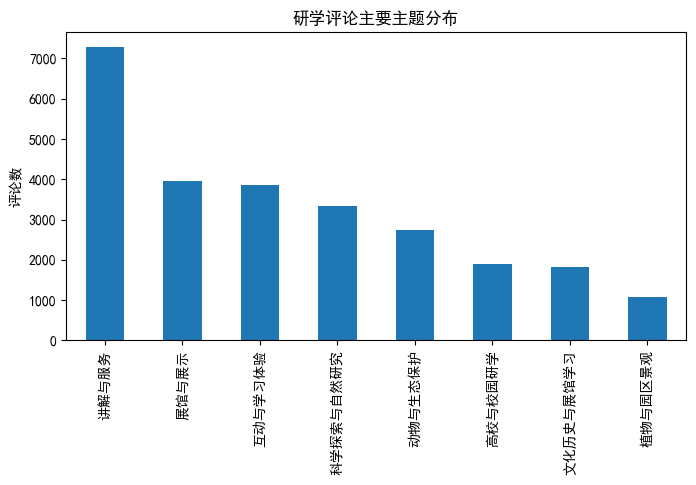

In [67]:

dominant_topic_labels = dominant_topics.map(topic_labels)
dominant_topic_labels.value_counts().plot(kind='bar', figsize=(8,4))
plt.title("研学评论主要主题分布")
plt.ylabel("评论数")
plt.show()

In [76]:
topic_dist_df_1["dominant_topic"] = dominant_topics                          # 比如 'Topic_3'
topic_dist_df_1["dominant_topic_label"] = dominant_topics.map(topic_labels) # 比如 '科普体验'

In [79]:
sentiment_counts = topic_dist_df_1.groupby(["dominant_topic_label", "sentiment"]).size().unstack(fill_value=0)
sentiment_ratio = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)


In [80]:
sentiment_ratio

sentiment,中性评论,正面评论,负面评论
dominant_topic_label,,,
互动与学习体验,0.012182,0.981337,0.006480
动物与生态保护,0.016053,0.968625,0.015323
展馆与展示,0.017988,0.977958,0.004054
文化历史与展馆学习,0.001642,0.998358,0.000000
植物与园区景观,0.022284,0.968431,0.009285
科学探索与自然研究,0.048984,0.922640,0.028375
讲解与服务,0.052740,0.854278,0.092982
高校与校园研学,0.027880,0.965281,0.006839


In [81]:
region_counts = topic_dist_df_1.groupby(["dominant_topic_label", "region"]).size().unstack(fill_value=0)
region_ratio = region_counts.div(region_counts.sum(axis=1), axis=0)

In [82]:
region_counts

region,东北地区,华东地区,华中地区,华北地区,华南地区,西北地区,西南地区
dominant_topic_label,,,,,,,
互动与学习体验,97,1534,449,577,442,261,498
动物与生态保护,142,1139,175,318,377,112,478
展馆与展示,228,1152,396,993,270,377,531
文化历史与展馆学习,6,48,1694,13,43,10,13
植物与园区景观,64,270,69,212,198,50,214
科学探索与自然研究,136,1237,195,431,464,259,626
讲解与服务,486,2244,713,1280,622,745,1191
高校与校园研学,47,983,340,138,198,63,132


求得区域总权重是什么

In [84]:
# 假设你已经有 topic_dist_df_1
df = topic_dist_df_1.copy()

# 1. 确定主题列（自动识别所有以 "Topic_" 开头的列）
topic_cols = [col for col in df.columns if col.startswith("Topic_")]

# 2. 设置阈值（比如 0.2），大于这个值视为“涉及该主题”
threshold = 0.2

# 3. 构建一个新的布尔矩阵，表示每条评论是否“涉及”某个主题（按行）
topic_flags = df[topic_cols] > threshold  # DataFrame: True / False

# 4. 添加 region 信息，准备按区域统计
topic_flags["region"] = df["region"]

# 5. 按区域分组，统计每个主题在各区域出现的次数（True 被当作 1）
region_topic_counts = topic_flags.groupby("region")[topic_cols].sum().T

# 6. 如果你还想计算“每个主题中，不同区域占比”，可加上：
region_topic_ratio = region_topic_counts.div(region_topic_counts.sum(axis=1), axis=0)


In [85]:
region_topic_counts

region,东北地区,华东地区,华中地区,华北地区,华南地区,西北地区,西南地区
Topic_1,645,3299,1026,1747,998,985,1682
Topic_2,220,1894,367,588,651,216,825
Topic_3,379,1928,656,1428,445,631,949
Topic_4,233,2119,351,708,779,435,1004
Topic_5,110,672,183,436,362,150,434
Topic_6,124,1568,519,296,368,137,325
Topic_7,214,2569,731,996,774,468,957
Topic_8,26,214,1769,65,84,49,56


In [97]:
# 假设 topic_dist_df_1 已加载
df = topic_dist_df_1.copy()

# 1. 确定主题列
topic_cols = [col for col in df.columns if col.startswith("Topic_")]

# 2. 按 region 分组，对每个主题的概率求和（即“每个主题在某个区域的累计贡献”）
region_topic_soft_counts = df.groupby("region")[topic_cols].sum().T  # 行：主题，列：区域

# 计算每个区域内，各主题所占的比例（每列为区域，列内部归一化）
region_topic_soft_ratio_by_region = region_topic_soft_counts.div(region_topic_soft_counts.sum(axis=0), axis=1)

In [98]:
region_topic_soft_counts

region,东北地区,华东地区,华中地区,华北地区,华南地区,西北地区,西南地区
Topic_1,411.437748,1976.914736,611.784004,1092.110685,559.295765,612.296640,1012.602731
Topic_2,140.849067,1174.066271,220.923253,366.347805,386.611179,138.975084,504.850005
Topic_3,222.512867,1149.149599,404.219904,981.338251,270.737724,375.484597,536.779944
Topic_4,133.764486,1193.457293,215.518969,418.810677,441.907512,262.480653,574.823324
Topic_5,82.860326,424.250547,125.727828,266.665518,216.328543,88.425936,261.059318
Topic_6,69.386283,990.488011,332.358902,185.471135,214.769976,87.234446,192.255028
Topic_7,115.044603,1475.352242,452.790050,569.919138,431.177588,266.902062,519.576410
Topic_8,30.144620,223.321301,1667.677090,81.336791,93.171713,45.200583,81.053240


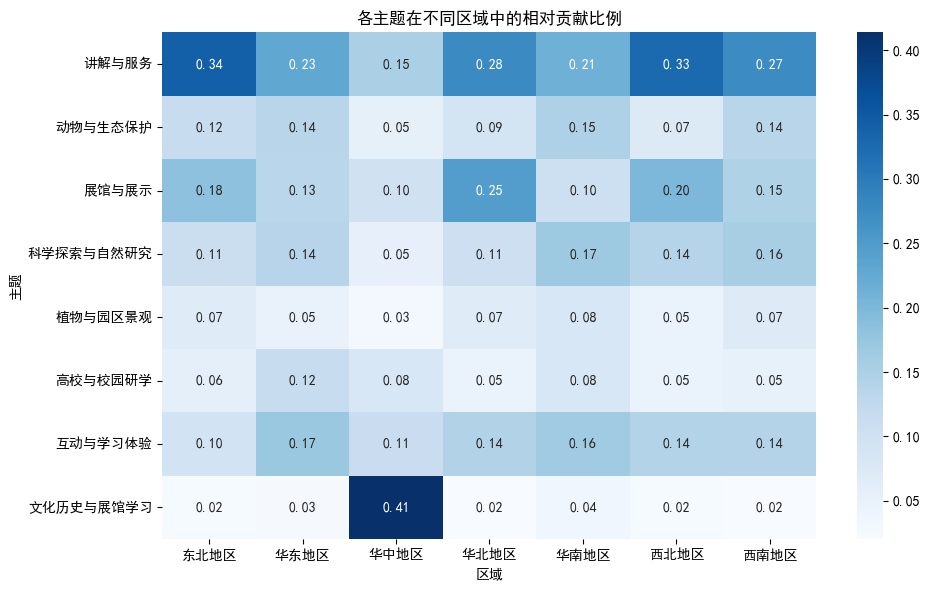

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
# 替换 index（主题）为中文标签
region_topic_soft_ratio_by_region.index = region_topic_soft_ratio_by_region.index.map(topic_labels)
plt.figure(figsize=(10, 6))
sns.heatmap(region_topic_soft_ratio_by_region, annot=True, cmap="Blues", fmt=".2f")
plt.title("各主题在不同区域中的相对贡献比例")
plt.xlabel("区域")
plt.ylabel("主题")
plt.tight_layout()
plt.show()
